Car_Name: Name of the car

Year: Year of manufacture

Selling_Price: Price at which the car is being sold

Present_Price: Current market price of the car

Kms_Driven: Total kilometers driven

Fuel_Type: Type of fuel the car uses (e.g., Petrol, Diesel)

Seller_Type: Type of seller (e.g., Dealer, Individual)

Transmission: Type of transmission (e.g., Manual, Automatic)

Owner: Number of previous owners

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('car data.csv')

In [3]:
data.head(2)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0


### Data Cleaning

In [4]:
# Check missing values
data.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

### Understand the data

In [5]:
data['Fuel_Type'].value_counts()

Fuel_Type
Petrol    239
Diesel     60
CNG         2
Name: count, dtype: int64

In [6]:
data['Seller_Type'].value_counts()

Seller_Type
Dealer        195
Individual    106
Name: count, dtype: int64

In [7]:
data['Transmission'].value_counts()

Transmission
Manual       261
Automatic     40
Name: count, dtype: int64

### Feature Engineering

In [8]:
data['Year'].max()

2018

The maximum year of the car is 2018. So I assume we are in 2019 to predict the car price.

In [9]:
# Create car age
data['Car_Age'] = data['Year'].max() - data['Year']


In [10]:
data.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner', 'Car_Age'],
      dtype='object')

In [11]:
# Turn text into numerical data
fuel_dummies = pd.get_dummies(data['Fuel_Type'], prefix='Fuel')
seller_dummies = pd.get_dummies(data['Seller_Type'], prefix='Seller')
transmission_dummies = pd.get_dummies(data['Transmission'], prefix='Transmission')

# Concat to main dataset
data = pd.concat([data, fuel_dummies], axis=1)
data = pd.concat([data, seller_dummies], axis=1)
data = pd.concat([data, transmission_dummies], axis=1)

# Drop columns
data.drop('Fuel_Type', axis=1, inplace=True)
data.drop('Seller_Type', axis=1, inplace=True)
data.drop('Transmission', axis=1, inplace=True)

# Turn into 1 or 0
columns_to_convert = ['Fuel_CNG', 'Fuel_Diesel', 'Fuel_Petrol', 
                      'Seller_Dealer', 'Seller_Individual', 
    
                      'Transmission_Automatic', 'Transmission_Manual']
for column in columns_to_convert:
    data[column] = data[column].map({True: 1, False: 0})


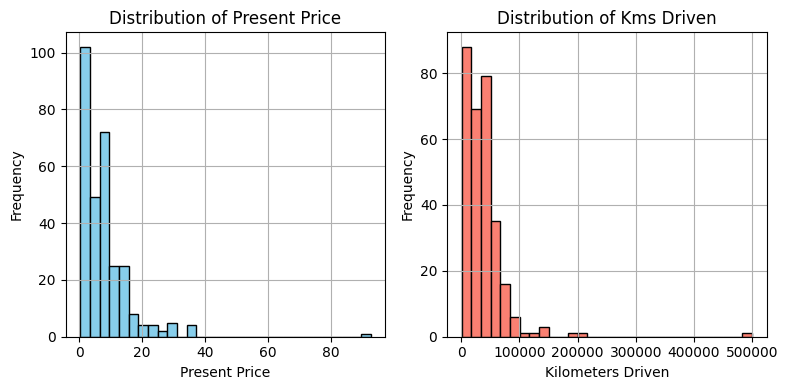

In [12]:
# Check distribution
plt.figure(figsize=(8, 4))

# Histogram for Present_Price
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
data['Present_Price'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Present Price')
plt.xlabel('Present Price')
plt.ylabel('Frequency')

# Histogram for Kms_Driven
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
data['Kms_Driven'].hist(bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Kms Driven')
plt.xlabel('Kilometers Driven')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The data are right-skewed!

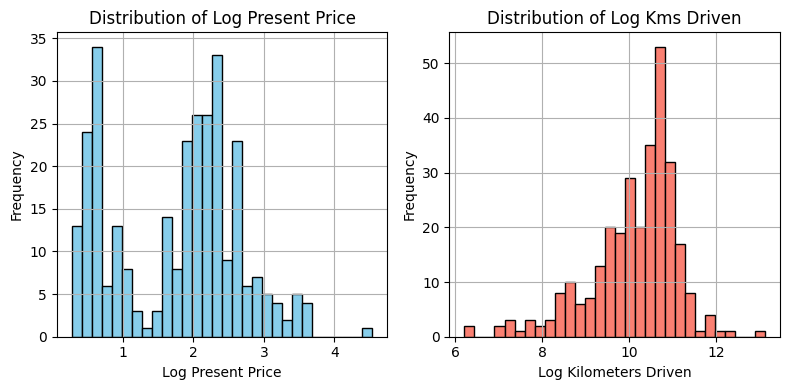

In [13]:
data['Log_Present_Price'] = np.log1p(data['Present_Price'])
data['Log_Kms_Driven'] = np.log1p(data['Kms_Driven'])

plt.figure(figsize=(8, 4))

# Histogram for Log_Present_Price
plt.subplot(1, 2, 1)
data['Log_Present_Price'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Log Present Price')
plt.xlabel('Log Present Price')
plt.ylabel('Frequency')

# Histogram for Log_Kms_Driven
plt.subplot(1, 2, 2)
data['Log_Kms_Driven'].hist(bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Log Kms Driven')
plt.xlabel('Log Kilometers Driven')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

_____

### EDA

In [14]:
data.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Owner', 'Car_Age', 'Fuel_CNG', 'Fuel_Diesel', 'Fuel_Petrol',
       'Seller_Dealer', 'Seller_Individual', 'Transmission_Automatic',
       'Transmission_Manual', 'Log_Present_Price', 'Log_Kms_Driven'],
      dtype='object')

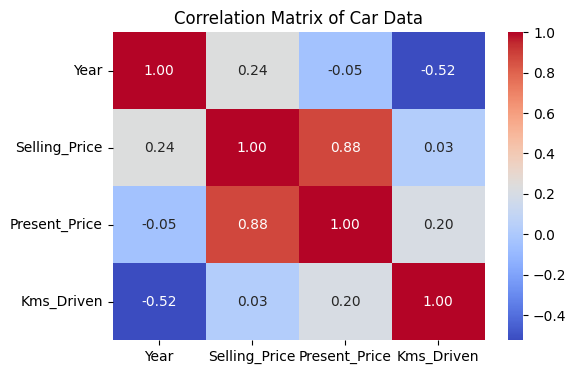

In [15]:
# Correlation
num_data =  data[['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven']]
corr_matrix = num_data.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Car Data')
plt.show()

This result is expected. The selling and present price has a strong positive relationship.

In [16]:
num_data.describe()

,Year,Selling_Price,Present_Price,Kms_Driven
count,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980
std,2.891554,5.082812,8.644115,38886.883882
min,2003.000000,0.100000,0.320000,500.000000
25%,2012.000000,0.900000,1.200000,15000.000000
50%,2014.000000,3.600000,6.400000,32000.000000
75%,2016.000000,6.000000,9.900000,48767.000000
max,2018.000000,35.000000,92.600000,500000.000000


In [17]:
data.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Car_Age,Fuel_CNG,Fuel_Diesel,Fuel_Petrol,Seller_Dealer,Seller_Individual,Transmission_Automatic,Transmission_Manual,Log_Present_Price,Log_Kms_Driven
0,ritz,2014,3.35,5.59,27000,0,4,0,0,1,1,0,0,1,1.885553,10.203629
1,sx4,2013,4.75,9.54,43000,0,5,0,1,0,1,0,0,1,2.355178,10.668979
2,ciaz,2017,7.25,9.85,6900,0,1,0,0,1,1,0,0,1,2.384165,8.839422
3,wagon r,2011,2.85,4.15,5200,0,7,0,0,1,1,0,0,1,1.638997,8.556606
4,swift,2014,4.60,6.87,42450,0,4,0,1,0,1,0,0,1,2.063058,10.656106


________

### Prediction model

In [18]:
X = data.drop(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven'], axis=1)
y = data['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [19]:
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 5.45
R² Score: 0.76


### Apply Polynomial Features

Polynomial Features:

Sometimes, relationships between features and the target are not linear. Adding polynomial features can help capture such non-linear relationships.

In [20]:
poly = PolynomialFeatures(degree=2)

# Create a pipeline that includes polynomial feature transformation and linear regression
model = Pipeline([
    ('polynomial_features', poly),
    ('linear_regression', LinearRegression())
])

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 1.06
R² Score: 0.95


In [21]:
# Evalute the model on the training data
y_train_pred = model.predict(X_train_scaled)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f"Training Data - Mean Squared Error (MSE): {train_mse:.2f}")
print(f"Training Data - R² Score: {train_r2:.2f}")
print(f"Test Data - Mean Squared Error (MSE): {mse:.2f}")
print(f"Test Data - R² Score: {r2:.2f}")

Training Data - Mean Squared Error (MSE): 0.60
Training Data - R² Score: 0.98
Test Data - Mean Squared Error (MSE): 1.06
Test Data - R² Score: 0.95


The model is overfitting.

In [22]:
X_scaled = scaler.fit_transform(X)

cv_scores_mse = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')

# Print the average MSE and R2 scores from cross-validation
print("Average Cross-Validated MSE:", -np.mean(cv_scores_mse))
print("Average Cross-Validated R² Score:", np.mean(cv_scores_r2))

Average Cross-Validated MSE: 1.673049547195078e+23
Average Cross-Validated R² Score: -8.615993705516049e+21


Given the persistent issues with extremely high Mean Squared Error (MSE) and extremely negative R² scores, even in simpler models like linear regression without polynomial features, it's clear that linear models may not be suitable for your dataset. These outcomes suggest a fundamental mismatch between the model type and the data characteristics, or possibly underlying issues with data quality or feature engineering.

_____